In [1]:
from skimage import io, morphology, color, util, filters, draw
from scipy import stats
import numpy as np
from PIL import Image
import pandas as pd
import sknw

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", palette="Set2")
from IPython.display import display
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

data = "data/"
overview_file = "image_overview.csv"

In [2]:
def calculate_radius(p1, p2, p3):
    # from https://stackoverflow.com/questions/28910718/give-3-points-and-a-plot-circle/50974391#50974391
    temp = p2[0] * p2[0] + p2[1] * p2[1]
    bc = (p1[0] * p1[0] + p1[1] * p1[1] - temp) / 2
    cd = (temp - p3[0] * p3[0] - p3[1] * p3[1]) / 2
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])

    if abs(det) < 1.0e-6:
        return None

    # Center of circle
    cx = (bc*(p2[1] - p3[1]) - cd*(p1[1] - p2[1])) / det
    cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det

    radius = np.sqrt((cx - p1[0])**2 + (cy - p1[1])**2)
    return radius

def calculate_curvatures(points, dist=30):
    
    curvatures_all = list()
    
    for i in range(len(ps)):

        cur_curvatures = list()
        cur_line = ps[i]

        for i in range(dist, len(cur_line[:,0])-dist):

            xm1, x, xp1 = cur_line[i-dist,0], cur_line[i,0], cur_line[i+dist,0]
            ym1, y, yp1 = cur_line[i-dist,1], cur_line[i,1], cur_line[i+dist,1]

            r = calculate_radius((xm1, ym1), (x,y), (xp1, yp1))
            if r is not None:
                cur_curvatures.append(1/r)
                
        curvatures_all.extend(cur_curvatures)
    
    if len(curvatures_all) != 0:
        return curvatures_all
    else:
        return None
    
def calculate_angles(graph, n_points = 10, n_min = 10):

    nodes = graph.nodes()
    angles = list()

    for i in nodes:

        if len(graph.edges(i)) != 3:
            continue

        neighbors_idx = [j for j in graph.neighbors(i)]
        neighbors_pts = np.array([graph[i][j]['pts'] for j in neighbors_idx])
        neighbors_len = [len(j) for j in neighbors_pts]

        if sum(np.array(neighbors_len) > n_min) != 3:
            continue

        c = graph.nodes(data=True)[i]["o"]

        # find closest n points
        p = [0, 0, 0]
        for i in range(3):
            p[i] = neighbors_pts[i][np.argsort(np.sum((neighbors_pts[i] - c)**2, axis=1))[:n_points],:]

        # linear regression through all sets
        sets = [[0,1], [1,2], [0,2]]
        r_vals = list()
        for i in range(3):
            a, b = sets[i][0], sets[i][1]
            temp_data = np.concatenate((p[a], p[b]), axis=0)

            _, _, r_value, _, _ = stats.linregress(temp_data)
            r_squared = r_value**2

            r_vals.append(r_squared)

        best_idx = sets[np.argmax(r_vals)]
        last_idx = list(set([0,1,2]).difference(set(best_idx)))[0]

        # create two lines, one through two best sets and one through last set. 
        temp_data = np.concatenate((p[best_idx[0]], p[best_idx[1]]), axis=0)
        slope1, _, _, _, _ = stats.linregress(temp_data)
        slope2, _, _, _, _ = stats.linregress(p[last_idx][:,0], p[last_idx][:,1])
        
        if np.isnan(slope1): slope1=1000
        if np.isnan(slope2): slope2=1000

        alpha, beta = np.arctan(slope1)*180/3.14, np.arctan(slope2)*180/3.14
        angle = alpha - beta
        #angle = (m1 - m2)*180/3.14
        if angle < 0:
            angle = -angle
        if angle > 90:
            angle = 180 - angle

        angles.append(angle)
        
    return angles

def box_fractal_dim(Z, threshold=0.9):
    # From https://github.com/rougier/numpy-100 (#87)
    # Only for 2d image
    assert(len(Z.shape) == 2)
    
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])

    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

In [3]:
img_overview = pd.read_csv(data+overview_file)
img_overview

,img_index,input_img_fname,target_img_fname,binary_threshold,segmentation_fname,gene
0,0,0_brightfield.jpg,0_fluorescence.jpg,15,0_target.jpg,wt
1,1,1_brightfield.jpg,1_fluorescence.jpg,25,1_target.jpg,wt
2,2,2_brightfield.jpg,2_fluorescence.jpg,15,2_target.jpg,wt
3,3,3_brightfield.jpg,3_fluorescence.jpg,25,3_target.jpg,wt
4,4,4_brightfield.jpg,4_fluorescence.jpg,15,4_target.jpg,wt
5,5,5_brightfield.jpg,5_fluorescence.jpg,25,5_target.jpg,wt
6,6,6_brightfield.jpg,6_fluorescence.jpg,15,6_target.jpg,wt
7,7,7_brightfield.jpg,7_fluorescence.jpg,25,7_target.jpg,wt
8,9,9_brightfield_chsC.jpg,9_fluorescence_chsC.jpg,20,9_target.jpg,chsc
9,10,10a_brightfield_chsC.png,10a_fluorescence_chsC.png,25,10a_target.jpg,chsc


In [4]:
branching_freqs = list()
curvatures_all = list()
angles_all = list()
internodal_all = list()
box_counting_dims_all = list()

pixels_per_hyphal_element = 50

n_hours = 24

for idx in range(len(img_overview)):

    fl_fname = img_overview.at[idx, "target_img_fname"]
    fl_img  = io.imread(data + fl_fname)
    fl_img = fl_img[:,:,2]
    fl_img = util.img_as_ubyte(fl_img)
    
    
    threshold = img_overview.at[idx, "binary_threshold"]

    bin_img = fl_img.copy()
    bin_img[bin_img >= threshold] = 255
    bin_img[bin_img < threshold] = 0

    bin_img = bin_img.astype(np.bool)

    bin_img = morphology.remove_small_objects(bin_img, min_size=10000, connectivity=2)

    bin_img = filters.median(bin_img, selem=morphology.square(5))

    ske_img = morphology.skeletonize(bin_img)
    ske_img = morphology.remove_small_objects(ske_img, min_size=1000, connectivity=2)
    
    # build graph from skeleton
    graph = sknw.build_sknw(ske_img)

    # draw node by o
    nodes = graph.nodes()
    bs = np.array([nodes[i]['o'] for i in nodes if len(graph.edges(i))>=3])
    ts = np.array([nodes[i]['o'] for i in nodes if len(graph.edges(i))<=2])
    
    ps = list()
    internodal_lengths = list()

    for (s,e) in graph.edges():
        ps.append(graph[s][e]['pts'].astype(np.int32))
        
        if len([j for j in graph.neighbors(s)]) == 3 and len([j for j in graph.neighbors(s)]) == 3:
            internodal_lengths.append(len(graph[s][e]['pts'].astype(np.int32)))
        
    curvatures = calculate_curvatures(ps)
        
    branch_occurence = (len(bs))/graph.size(weight="weight")    
    n_hyphal_elements = (graph.size(weight="weight"))/pixels_per_hyphal_element
    
    curvatures_all.append(curvatures)
    branching_freqs.append(branch_occurence*pixels_per_hyphal_element/24)
    
    angles = calculate_angles(graph)
    angles_all.append(angles)
    
    internodal_all.append(internodal_lengths)
    
    box_counting_dims_all.append(box_fractal_dim(ske_img))
 
    
    


# Branching frequency

In [5]:
img_overview["branching_freqs"] = branching_freqs
img_overview["box_counting_dim"] = box_counting_dims_all
img_overview["mean_curvature"] = [np.mean(x) for x in curvatures_all]
img_overview["mean_angle"] = [np.mean(x) for x in angles_all]
img_overview

,img_index,input_img_fname,target_img_fname,binary_threshold,segmentation_fname,gene,branching_freqs,box_counting_dim,mean_curvature,mean_angle
0,0,0_brightfield.jpg,0_fluorescence.jpg,15,0_target.jpg,wt,0.015759,1.302626,0.004254,73.331330
1,1,1_brightfield.jpg,1_fluorescence.jpg,25,1_target.jpg,wt,0.013036,1.410648,0.005425,74.954610
2,2,2_brightfield.jpg,2_fluorescence.jpg,15,2_target.jpg,wt,0.014245,1.170156,0.004981,74.383899
3,3,3_brightfield.jpg,3_fluorescence.jpg,25,3_target.jpg,wt,0.018739,1.448176,0.004432,71.449223
4,4,4_brightfield.jpg,4_fluorescence.jpg,15,4_target.jpg,wt,0.021226,1.315881,0.004726,72.797602
5,5,5_brightfield.jpg,5_fluorescence.jpg,25,5_target.jpg,wt,0.018071,1.449200,0.004492,72.271448
6,6,6_brightfield.jpg,6_fluorescence.jpg,15,6_target.jpg,wt,0.019359,1.393574,0.004061,72.141909
7,7,7_brightfield.jpg,7_fluorescence.jpg,25,7_target.jpg,wt,0.014972,1.389426,0.006531,69.912388
8,9,9_brightfield_chsC.jpg,9_fluorescence_chsC.jpg,20,9_target.jpg,chsc,0.024396,1.394406,0.005866,70.062127
9,10,10a_brightfield_chsC.png,10a_fluorescence_chsC.png,25,10a_target.jpg,chsc,0.028973,1.319097,0.005930,69.962351


<AxesSubplot:xlabel='gene', ylabel='branching_freqs'>

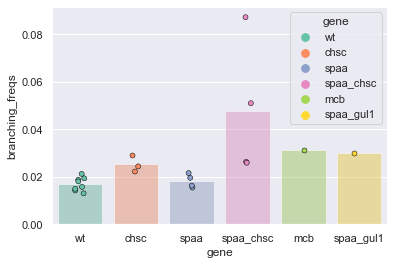

In [6]:
f, ax = plt.subplots()

sns.barplot(data=img_overview, x="gene", y="branching_freqs", alpha=0.5, ci=False, ax=ax)
sns.stripplot(data=img_overview, x="gene", hue="gene", y="branching_freqs", edgecolor="k", ax=ax, linewidth=0.5)

<AxesSubplot:xlabel='gene', ylabel='box_counting_dim'>

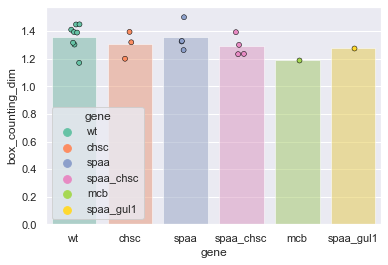

In [20]:
f, ax = plt.subplots()

sns.barplot(data=img_overview, x="gene", y="box_counting_dim", alpha=0.5, ci=False, ax=ax)
sns.stripplot(data=img_overview, x="gene", hue="gene", y="box_counting_dim", edgecolor="k", ax=ax, linewidth=0.5)

<AxesSubplot:xlabel='gene', ylabel='mean_curvature'>

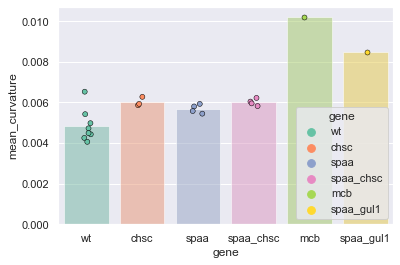

In [21]:
f, ax = plt.subplots()

sns.barplot(data=img_overview, x="gene", y="mean_curvature", alpha=0.5, ci=False, ax=ax)
sns.stripplot(data=img_overview, x="gene", hue="gene", y="mean_curvature", edgecolor="k", ax=ax, linewidth=0.5)

<AxesSubplot:xlabel='gene', ylabel='mean_angle'>

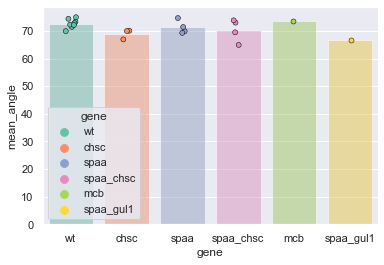

In [22]:
f, ax = plt.subplots()

sns.barplot(data=img_overview, x="gene", y="mean_angle", alpha=0.5, ci=False, ax=ax)
sns.stripplot(data=img_overview, x="gene", hue="gene", y="mean_angle", edgecolor="k", ax=ax, linewidth=0.5)

In [7]:
img_overview["mean_curvature"] = [np.mean(x) for x in curvatures_all]
img_overview

,img_index,input_img_fname,target_img_fname,binary_threshold,segmentation_fname,gene,branching_freqs,box_counting_dim,mean_curvature,mean_angle
0,0,0_brightfield.jpg,0_fluorescence.jpg,15,0_target.jpg,wt,0.015759,1.302626,0.004254,73.331330
1,1,1_brightfield.jpg,1_fluorescence.jpg,25,1_target.jpg,wt,0.013036,1.410648,0.005425,74.954610
2,2,2_brightfield.jpg,2_fluorescence.jpg,15,2_target.jpg,wt,0.014245,1.170156,0.004981,74.383899
3,3,3_brightfield.jpg,3_fluorescence.jpg,25,3_target.jpg,wt,0.018739,1.448176,0.004432,71.449223
4,4,4_brightfield.jpg,4_fluorescence.jpg,15,4_target.jpg,wt,0.021226,1.315881,0.004726,72.797602
5,5,5_brightfield.jpg,5_fluorescence.jpg,25,5_target.jpg,wt,0.018071,1.449200,0.004492,72.271448
6,6,6_brightfield.jpg,6_fluorescence.jpg,15,6_target.jpg,wt,0.019359,1.393574,0.004061,72.141909
7,7,7_brightfield.jpg,7_fluorescence.jpg,25,7_target.jpg,wt,0.014972,1.389426,0.006531,69.912388
8,9,9_brightfield_chsC.jpg,9_fluorescence_chsC.jpg,20,9_target.jpg,chsc,0.024396,1.394406,0.005866,70.062127
9,10,10a_brightfield_chsC.png,10a_fluorescence_chsC.png,25,10a_target.jpg,chsc,0.028973,1.319097,0.005930,69.962351


# Angles

In [8]:
angle_df = img_overview.copy()
angle_df["angles"] = angles_all

angle_df = angle_df.loc[:, ["gene", "angles"]]

angle_df = angle_df.explode('angles')
angle_df

,gene,angles
0,wt,51.7034
0,wt,89.2528
0,wt,83.2388
0,wt,62.5702
0,wt,79.0236
...,...,...
20,spaa_gul1,56.9726
20,spaa_gul1,66.6364
20,spaa_gul1,64.95
20,spaa_gul1,57.3313


In [9]:
angle_df["angles"] = angle_df["angles"].astype(float)

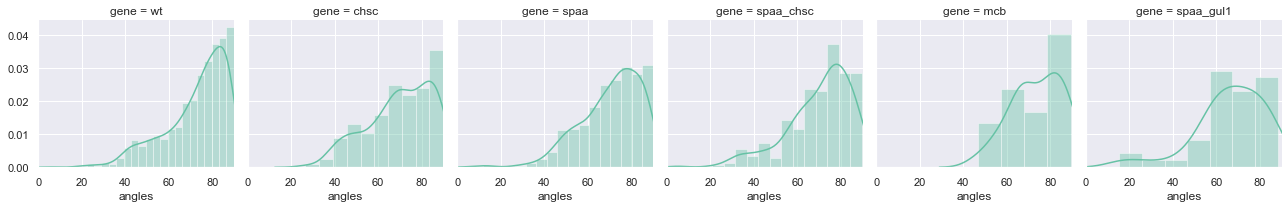

In [10]:
g = sns.FacetGrid(data=angle_df, col="gene", xlim=(0, 90))
g.map(sns.distplot, "angles")

# Curvatures

In [11]:
curv_df = img_overview.copy()
curv_df["curvatures"] = curvatures_all

curv_df = curv_df.loc[:, ["img_index", "gene", "curvatures"]]

curv_df = curv_df.explode('curvatures')
curv_df["curvatures"] = curv_df["curvatures"].astype(float)
curv_df

,img_index,gene,curvatures
0,0,wt,0.005814
0,0,wt,0.005814
0,0,wt,0.005814
0,0,wt,0.003892
0,0,wt,0.005814
...,...,...,...
20,21,spaa_gul1,0.005461
20,21,spaa_gul1,0.005461
20,21,spaa_gul1,0.005461
20,21,spaa_gul1,0.004396


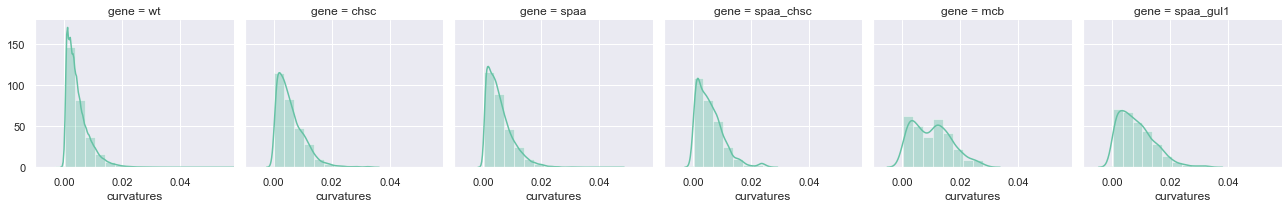

In [12]:
g = sns.FacetGrid(data=curv_df, col="gene", xlim=(-0.01, max(curv_df["curvatures"])))
g.map(sns.distplot, "curvatures", 
      bins=np.arange(-0.01, max(curv_df["curvatures"]), (max(curv_df["curvatures"])+0.01)/20))

In [13]:
curv_df["curvatures"].reset_index(drop=True)

0         0.005814
1         0.005814
2         0.005814
3         0.003892
4         0.005814
            ...   
113369    0.005461
113370    0.005461
113371    0.005461
113372    0.004396
113373    0.004396
Name: curvatures, Length: 113374, dtype: float64

# Angle estimations and plot

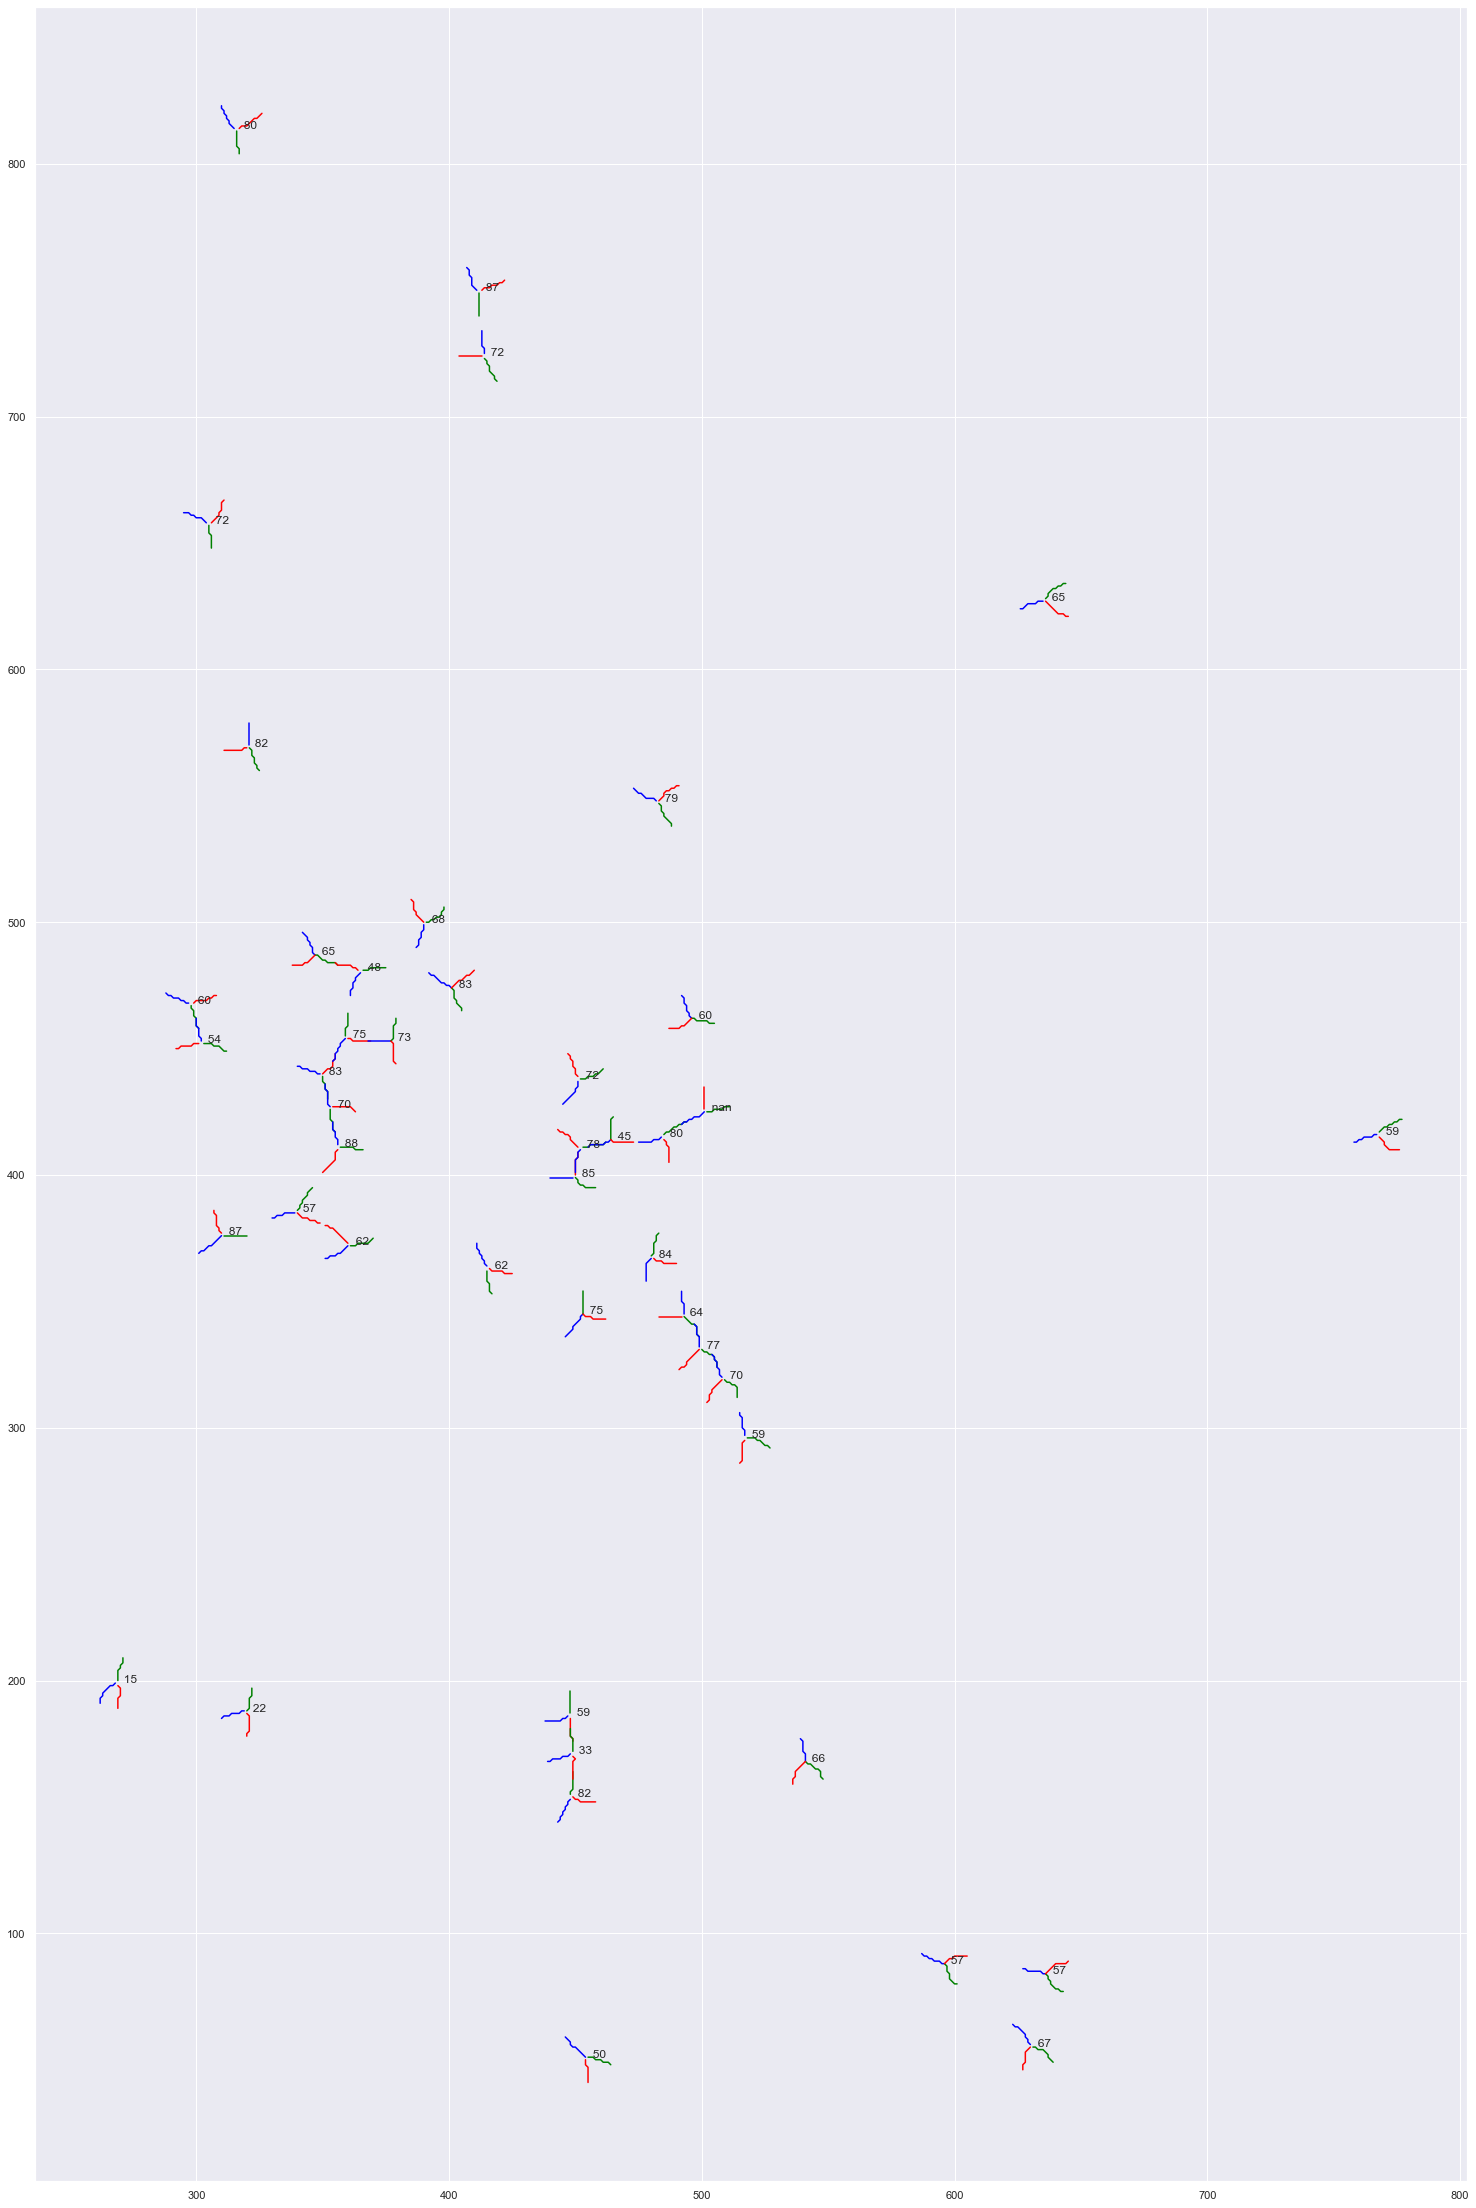

In [14]:
f, ax = plt.subplots(figsize=[30,40])

nodes = graph.nodes()
angles = list()

n_points = 10
n_min = 10

for i in nodes:
    
    if len(graph.edges(i)) != 3:
        continue
    
    neighbors_idx = [j for j in graph.neighbors(i)]
    neighbors_pts = np.array([graph[i][j]['pts'] for j in neighbors_idx])
    neighbors_len = [len(j) for j in neighbors_pts]
    
    if sum(np.array(neighbors_len) > n_min) != 3:
        continue
    
    c = graph.nodes(data=True)[i]["o"]
    
    # find closest 5 points
    p = [0, 0, 0]
    for i in range(3):
        p[i] = neighbors_pts[i][np.argsort(np.sum((neighbors_pts[i] - c)**2, axis=1))[:n_points],:]
        
    # linear regression through all sets
    sets = [[0,1], [1,2], [0,2]]
    r_vals = list()
    for i in range(3):
        a, b = sets[i][0], sets[i][1]
        temp_data = np.concatenate((p[a], p[b]), axis=0)
        
        _, _, r_value, _, _ = stats.linregress(temp_data)
        r_squared = r_value**2
        
        r_vals.append(r_squared)
    
    best_idx = sets[np.argmax(r_vals)]
    last_idx = list(set([0,1,2]).difference(set(best_idx)))[0]
    
    # create two lines, one through two best sets and one through last set. 
    temp_data = np.concatenate((p[best_idx[0]], p[best_idx[1]]), axis=0)
    slope1, _, _, _, _ = stats.linregress(temp_data)
    slope2, _, _, _, _ = stats.linregress(p[last_idx][:,0], p[last_idx][:,1])
    
    alpha, beta = np.arctan(slope1)*180/3.14, np.arctan(slope2)*180/3.14
    angle = alpha - beta
    #angle = (m1 - m2)*180/3.14
    if angle < 0:
        angle = -angle
    if angle > 90:
        angle = 180 - angle
    
    angles.append(angle)
    
    plt.plot(p[best_idx[0]][:, 0], p[best_idx[0]][:, 1], color="b")
    plt.plot(p[best_idx[1]][:, 0], p[best_idx[1]][:, 1], color="g")
    plt.plot(p[last_idx][:, 0], p[last_idx][:, 1], color="r")
    plt.text(c[0], c[1], f"  {angle:.0f}", fontsize=12) #angle:.0f
    

ax.set_aspect('equal')
plt.show()

# Internodal lengths

In [15]:
inter_df = img_overview.copy()
inter_df["internodal"] = internodal_all

inter_df = inter_df.loc[:, ["img_index", "gene", "internodal"]]

inter_df = inter_df.explode('internodal')
inter_df

,img_index,gene,internodal
0,0,wt,448
0,0,wt,279
0,0,wt,241
0,0,wt,259
0,0,wt,334
...,...,...,...
20,21,spaa_gul1,44
20,21,spaa_gul1,17
20,21,spaa_gul1,16
20,21,spaa_gul1,8


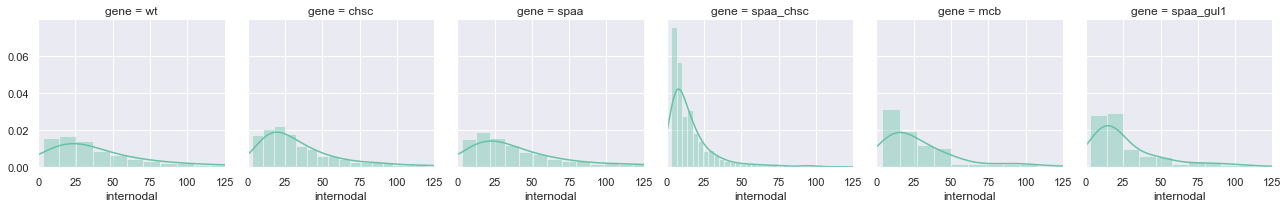

In [16]:
g = sns.FacetGrid(data=inter_df, col="gene", aspect=1, xlim=(0,125))
g.map(sns.distplot, "internodal")



In [17]:
np.unique(angles_all)

array([list([15.375942316743334, 60.04166493264549, 53.65628344802407, 71.6634105777139, 87.48437903143676, 80.48215423462227, 22.194909341253314, 81.83198312852899, 57.43699062321214, 65.4857818291045, 83.45393702068037, 70.20035124577284, 88.21910177592304, 75.43302638424916, 61.52935331502047, 48.110472885721805, 72.5176309231181, 68.42634840138832, 83.12075033751256, 87.43567243379616, 72.01491966439266, 61.59294587354214, 59.27845167516875, 81.64128688356686, 33.221708834016596, 85.3020228063806, 78.21825807698949, 71.89168728739355, 75.42754048157141, 49.82628895857996, 44.51021701205674, 84.0972451823681, 79.20434743089496, 80.00880092433606, 63.735016670983335, 60.171048272221554, 77.28709638444235, 70.05739935259693, 70.0951415304304, 58.86310864867815, 65.90850844807979, 56.972572695319016, 66.63636738071858, 64.94996991644524, 57.33128244016362, 59.10566657350954]),
       list([51.70344288049212, 89.25278309314011, 83.2388033241443, 62.57022239423567, 79.02359471654924, 88.

In [18]:
np.nan

nan

In [19]:
angles_all

[[51.70344288049212,
  89.25278309314011,
  83.2388033241443,
  62.57022239423567,
  79.02359471654924,
  88.84417704349754,
  82.94522793669434,
  89.25912753048601,
  77.06583787176129,
  83.58372185147566,
  53.06622303543581,
  47.540468363091115,
  70.65272881224672,
  87.71045804417732,
  88.10106041075917,
  89.25610087916347,
  88.0840862692858,
  84.30442894033447,
  86.38827169018764,
  42.91782217650125,
  86.3117659055095,
  55.052575176515134,
  86.47373661081353,
  63.73154395823682,
  83.07408243390528,
  88.39522844689537,
  85.25532526377191,
  81.92707054144144,
  81.08355945174125,
  86.49753382135567,
  89.8314421378688,
  86.00801961201583,
  86.23192170398578,
  87.2952134078177,
  49.60804767233574,
  63.53015886114386,
  79.86743427331818,
  81.11613863333923,
  83.8498992191287,
  79.57584107214399,
  88.88353804418799,
  78.58218544619754,
  45.094042631390934,
  61.60418368830213,
  53.21253504498784,
  80.34292341433898,
  44.804558747781,
  77.5124811974813